# TIØ4317 Project

Group members:
- Frederick Johan Pretlove
- Fabian Stoltenberg
- Hans Kristian Bjørgo Kværum
- Hedda Flemmen Holum

## Problem statement

This project investigates how fluctuations in the oil price, and the Norwegian Krone (NOK) exchange rate influence the stock prices of selected companies listed on the Oslo Stock Exchange (OSE). By applying time-series analysis, we aim to determine the explanatory power of these external economic factors in stock price prediction.

We will retrieve historical data via APIs (Yahoo Finance and Norges Bank) and implement ARIMA and ARIMAX models (see explanations in the “Empirical Analysis” section). Our goal is to compare their predictive performance and assess whether incorporating oil prices and exchange rates improves stock price forecasts beyond a baseline ARIMA model. If these external factors enhance predictive accuracy, this would indicate a relationship between commodity prices, exchange rates, and stock prices.

To ensure model robustness, we will conduct diagnostic tests for stationarity, autocorrelation, and heteroscedasticity. The findings will provide insights into the relationship between macroeconomic factors and energy stock prices, offering valuable guidance to investors and analysts seeking to better understand market dynamics.


In [56]:
#Imports

#Data manipulation and plotting
import pandas as pd #For reading files + data manipulation
import matplotlib.pyplot as plt  #For plotting
import numpy as np  #For data manipulation and calculations
import seaborn as sns # For plotting
from datetime import datetime #For date manipulation

#For statistical modelling
from statsmodels.tsa.stattools import adfuller #For ADF test
from statsmodels.tsa.stattools import kpss #For KPSS test
import warnings #To surpress KPSS warnings
from statsmodels.tsa.arima.model import ARIMA #For ARIMA modelling
from sklearn.metrics import mean_squared_error #For model evaluation

In [57]:
# Load the processed data 
df_commodities = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')[['Date','Price','% Change', 'Ticker']]
df_stocks = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx')[['Date', 'Price', '% Return', 'Ticker']]
df_exchange_rate = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx')[['Date','Mid', '% Change', 'Ticker']]

## Data

Our project utilizes three datasets covering the period from January 2018 to February 2025, providing the necessary historical information for our time-series analysis.

The first dataset consists of daily stock prices for selected companies listed on the Oslo Stock Exchange. In addition to stock prices, this dataset includes features such as trading volume, daily percentage return, cumulative return percentage, and stock ticker symbols.


In [58]:
df_stocks.head()

Date      Price  % Return  Ticker
0 2018-01-02  361.27866  0.637107  YAR-NO
1 2018-01-03  364.70940  0.949610  YAR-NO
2 2018-01-04  363.85170 -0.235174  YAR-NO
3 2018-01-05  367.28247  0.942903  YAR-NO
4 2018-01-08  375.09702  2.127668  YAR-NO

The second dataset contains daily exchange rates of various currencies against the Norwegian Krone (NOK), including USD/NOK, GBP/NOK, EUR/NOK, and CHF/NOK. This dataset provides information on bid and ask prices, percentage changes, and corresponding ticker symbols, allowing us to assess the impact of currency fluctuations on stock prices.


In [59]:
df_exchange_rate.head()

Date       Mid  % Change  Ticker
0 2018-01-02  8.370757 -0.273562  CHFNOK
1 2018-01-03  8.306228 -0.770886  CHFNOK
2 2018-01-04  8.296742 -0.114203  CHFNOK
3 2018-01-05  8.254831 -0.505150  CHFNOK
4 2018-01-08  8.278486  0.286559  CHFNOK

The third dataset includes daily prices of gas and oil over the same timeframe. Alongside commodity prices, the dataset also includes percentage changes and ticker symbols.

In [60]:
df_commodities.head()

Date      Price   % Change     Ticker
0 2018-01-02  50.781433  68.251837  HHGAS-FDS
1 2018-01-03  50.641342  -0.275871  HHGAS-FDS
2 2018-01-04  37.605713 -25.741081  HHGAS-FDS
3 2018-01-05  37.438774  -0.443919  HHGAS-FDS
4 2018-01-08  23.359003 -37.607457  HHGAS-FDS

The data was retrieved through Factset, as one of our group members has access through their part time job. Before analysis, we conducted preprocessing steps, including handling missing values, aligning timestamps across datasets, and standardizing variables to ensure consistency.

For our empirical analysis, we focus on oil prices as our commodity variable and use the mean exchange rate (the average of the four exchange rates) to capture broader currency fluctuations. These variables are selected based on their potential impact on stock prices and their relevance to the Norwegian energy sector.


To get a better understanding of the data we are dealing with, we performed Exploratory Data Analysis (EDA).

### Development of Select Stock Prices (2018-2025)

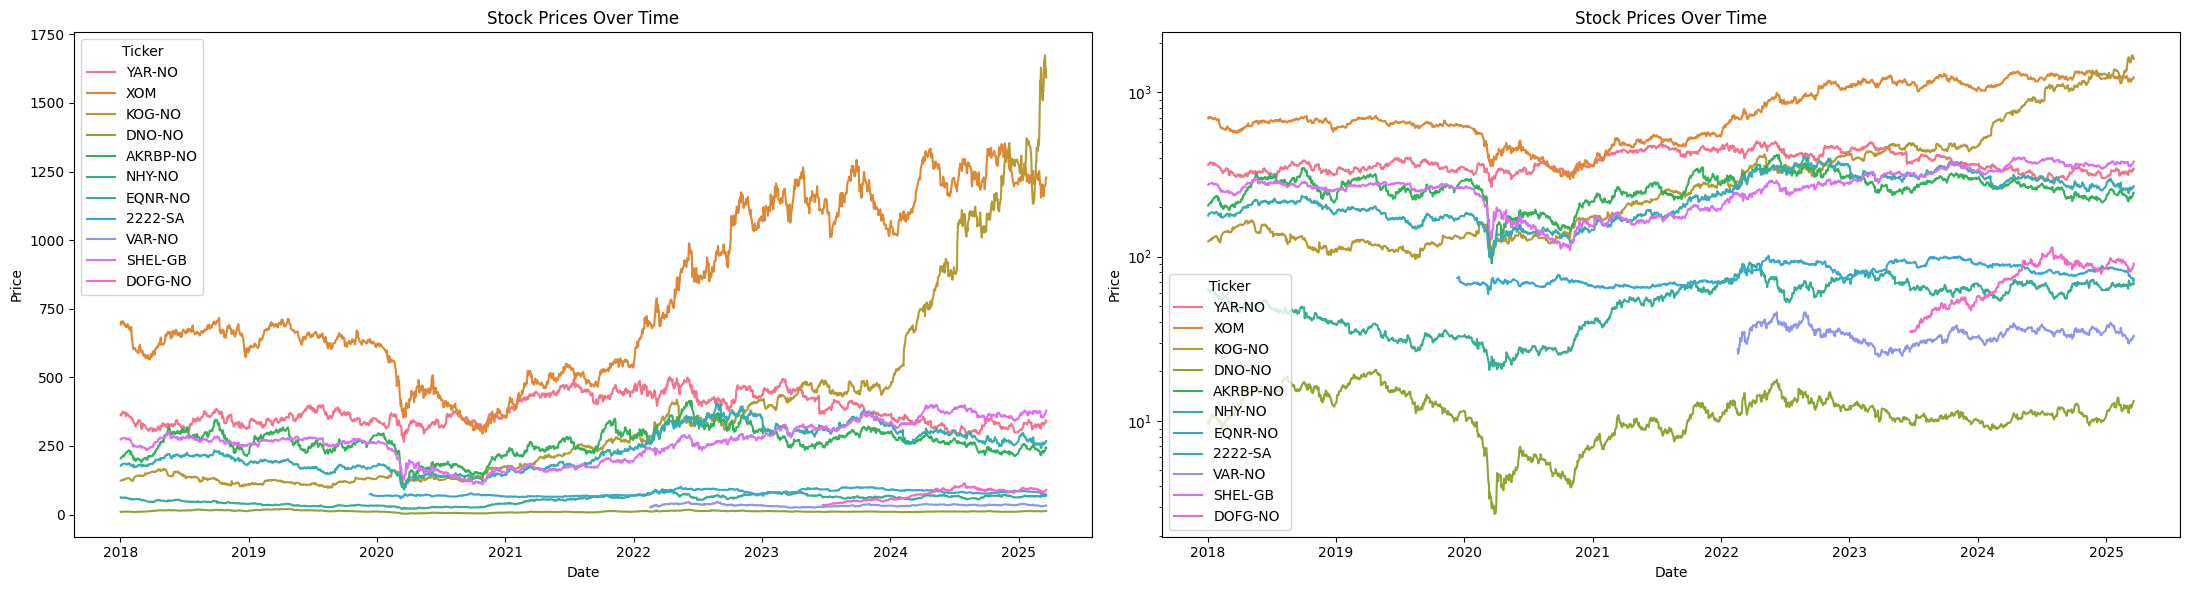

In [61]:
df_stocks = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx', parse_dates=['Date'])

fig, axes = plt.subplots(1, 2, figsize=(22, 6))

sns.lineplot(data=df_stocks, x='Date', y='Price', ax=axes[0], hue='Ticker')   
sns.lineplot(data=df_stocks, x='Date', y='Price', ax=axes[1], hue='Ticker')   

axes[0].set_title('Stock Prices Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')

axes[1].set_title('Stock Prices Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

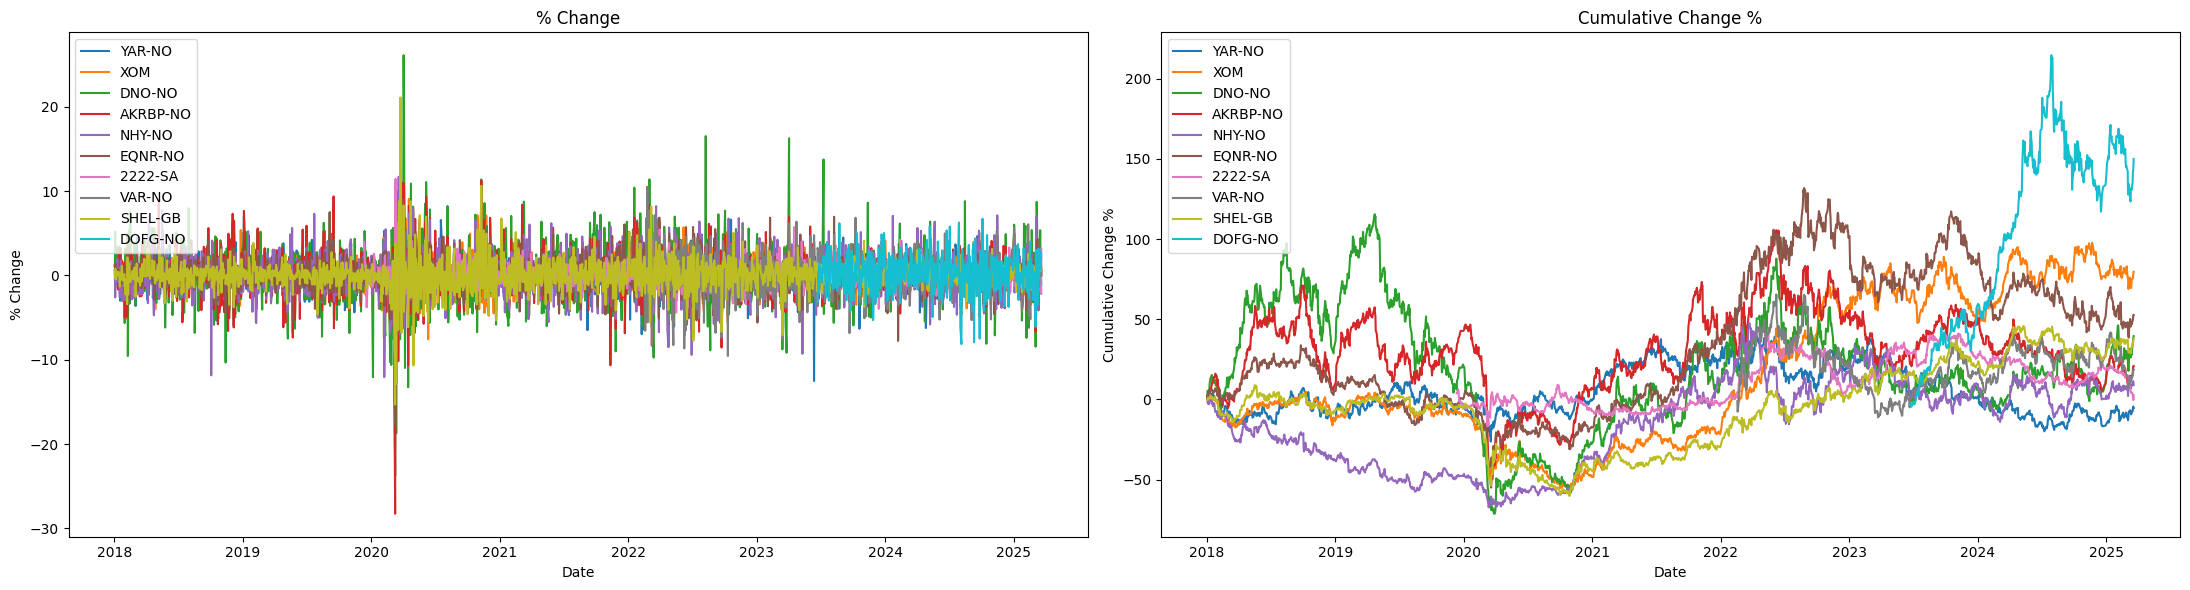

In [62]:
fig, axes = plt.subplots(1,2, figsize=(22,6))

plot_cols = ['% Change', 'Cumulative Change %']
plot_df = df_stocks[df_stocks.Ticker != 'KOG-NO'].copy() # Exclude Kongsberg Gruppen due to exceptional strock price increase

for i, col in enumerate(plot_cols):
    sns.lineplot(plot_df, x='Date', y=col, hue='Ticker', ax=axes[i])
    axes[i].set_title(col)    
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

### Development of Oil & Gas Prices (2018-2025)

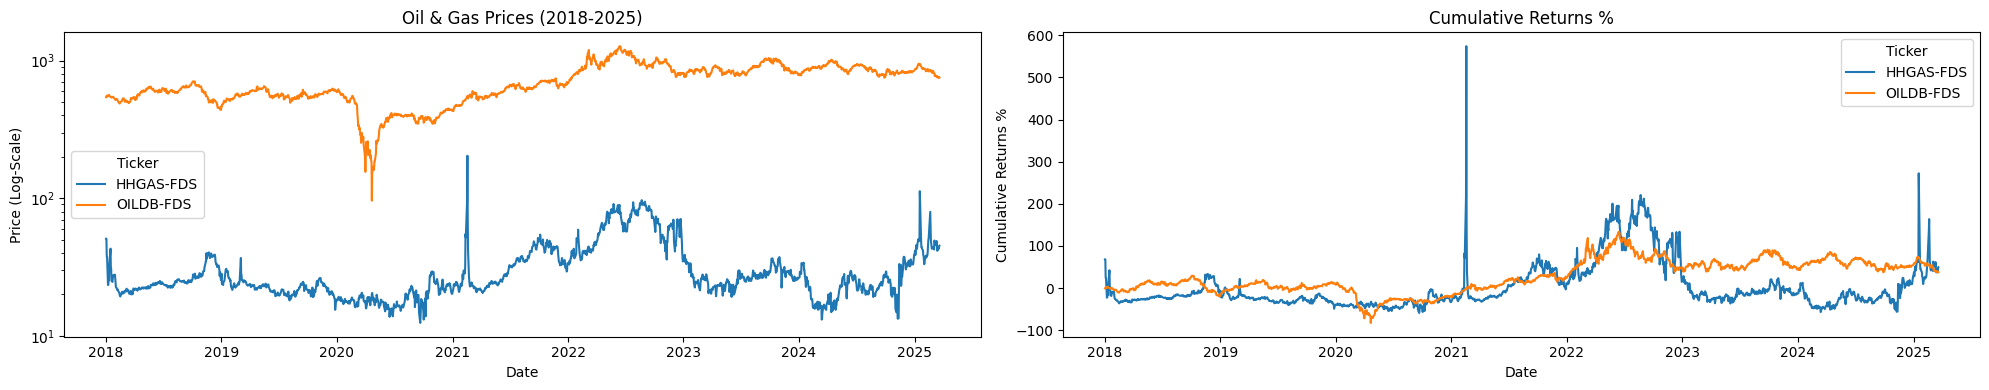

In [63]:
df_commodities = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx', parse_dates=['Date'])

data = df_commodities[df_commodities.Ticker.isin(['OILDB-FDS', 'HHGAS-FDS'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

sns.lineplot(data=data, x='Date', y='Price', hue='Ticker', ax=axes[0])
sns.lineplot(data=data, x='Date', y='Cumulative Change %', hue='Ticker', ax=axes[1])

axes[0].set_title('Oil & Gas Prices (2018-2025)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (Log-Scale)')
axes[0].set_yscale('log')

axes[1].set_title('Cumulative Returns %')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns %')

plt.tight_layout()
plt.show()

### Development of Exchange Rates (2018-2025)

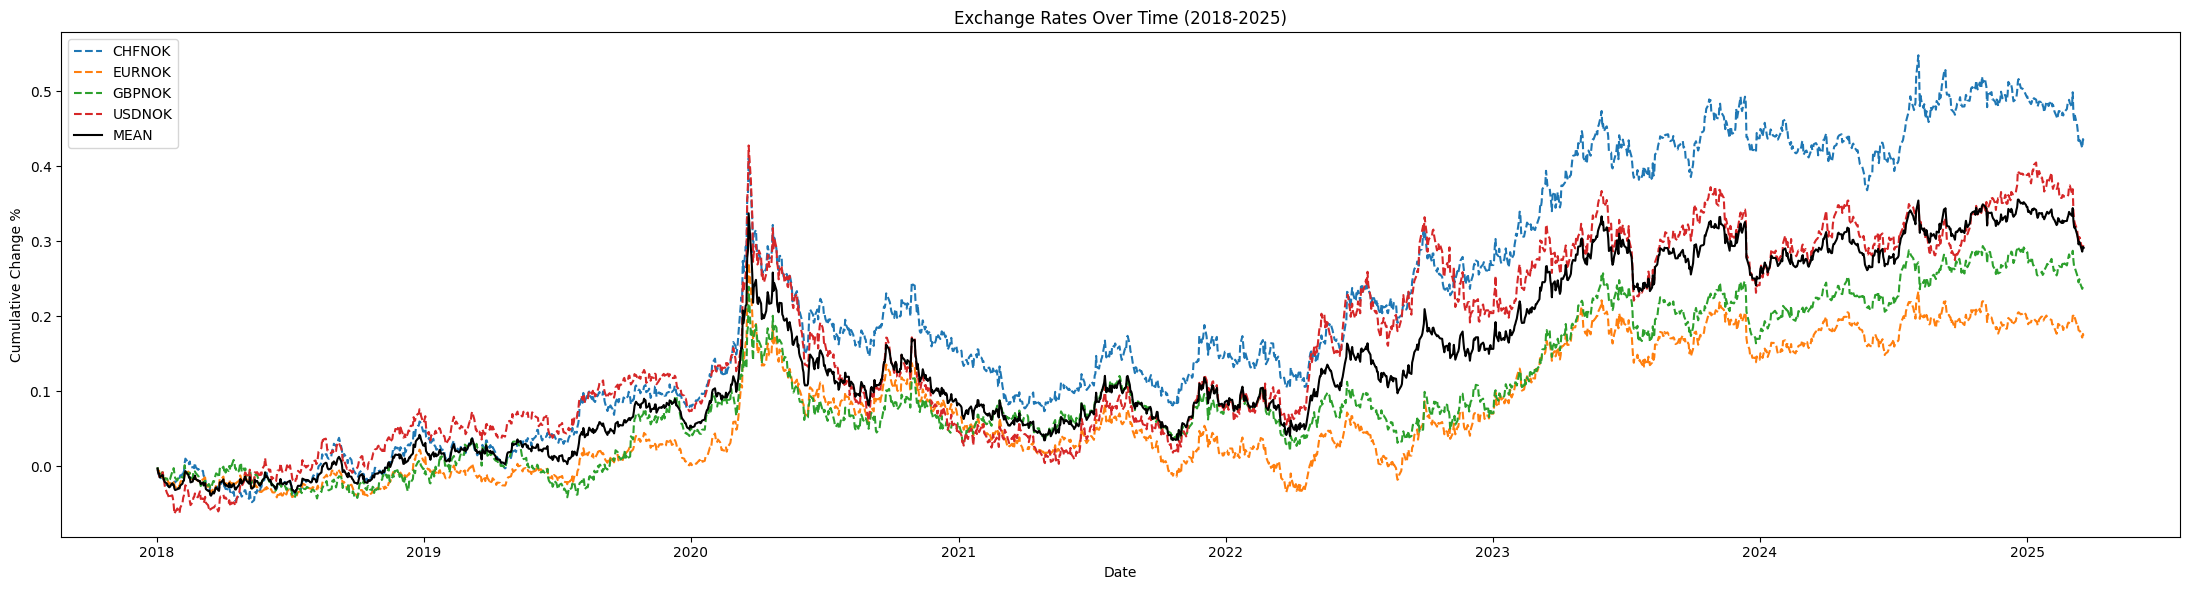

In [64]:
import numpy as np

currencies = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx', parse_dates=['Date'])

for col in [x for x in currencies.columns if '%' in x]:
    currencies[col] /= 100

currencies_pivot = currencies.pivot(index="Date", columns="Ticker", values=["Cumulative Change %"]).reset_index()
currencies_pivot.columns = currencies_pivot.columns.get_level_values(1)
currencies_pivot.rename(columns={"": "Date"}, inplace=True)

mean_df = currencies.groupby("Date").agg(daily_mean=pd.NamedAgg("% Change", "mean")).reset_index()
mean_df["LN_daily_mean"] = mean_df.daily_mean.apply(lambda x: np.log(1+x))
mean_df["Mean Cumulative Change %"] = mean_df.LN_daily_mean.cumsum().apply(lambda x: np.exp(x) - 1)
mean_df.rename(columns={'daily_mean': 'Mean % Change', 'Mean Cumulative Change %': 'MEAN'}, inplace=True)

data = currencies_pivot.merge(mean_df[['Date', 'MEAN']], on='Date', how='inner')#.melt(id_vars=['Date'], var_name='Ticker', value_name='Cumulative Change %')

fig, axes = plt.subplots(1, 1, figsize=(22, 6))

for col in data.columns[1:]:
    if col == 'MEAN':
        sns.lineplot(data=data, x='Date', y=col, label=col, ax=axes, color='black')
    else:
        sns.lineplot(data=data, x='Date', y=col, label=col, ax=axes, linestyle='--')


#sns.lineplot(data=data, x='Date', y='Cumulative Change %', hue='Ticker', ax=axes)
axes.set_title('Exchange Rates Over Time (2018-2025)')
axes.set_xlabel('Date')
axes.set_ylabel('Cumulative Change %')
axes.legend(loc='upper left')

plt.tight_layout()
plt.show()


**Comment:** the mean exchange rate represents the relative worth of the NOK, making it more robust 

### Cumulative Change of Energy Stocks vs. Oil & Gas Prices

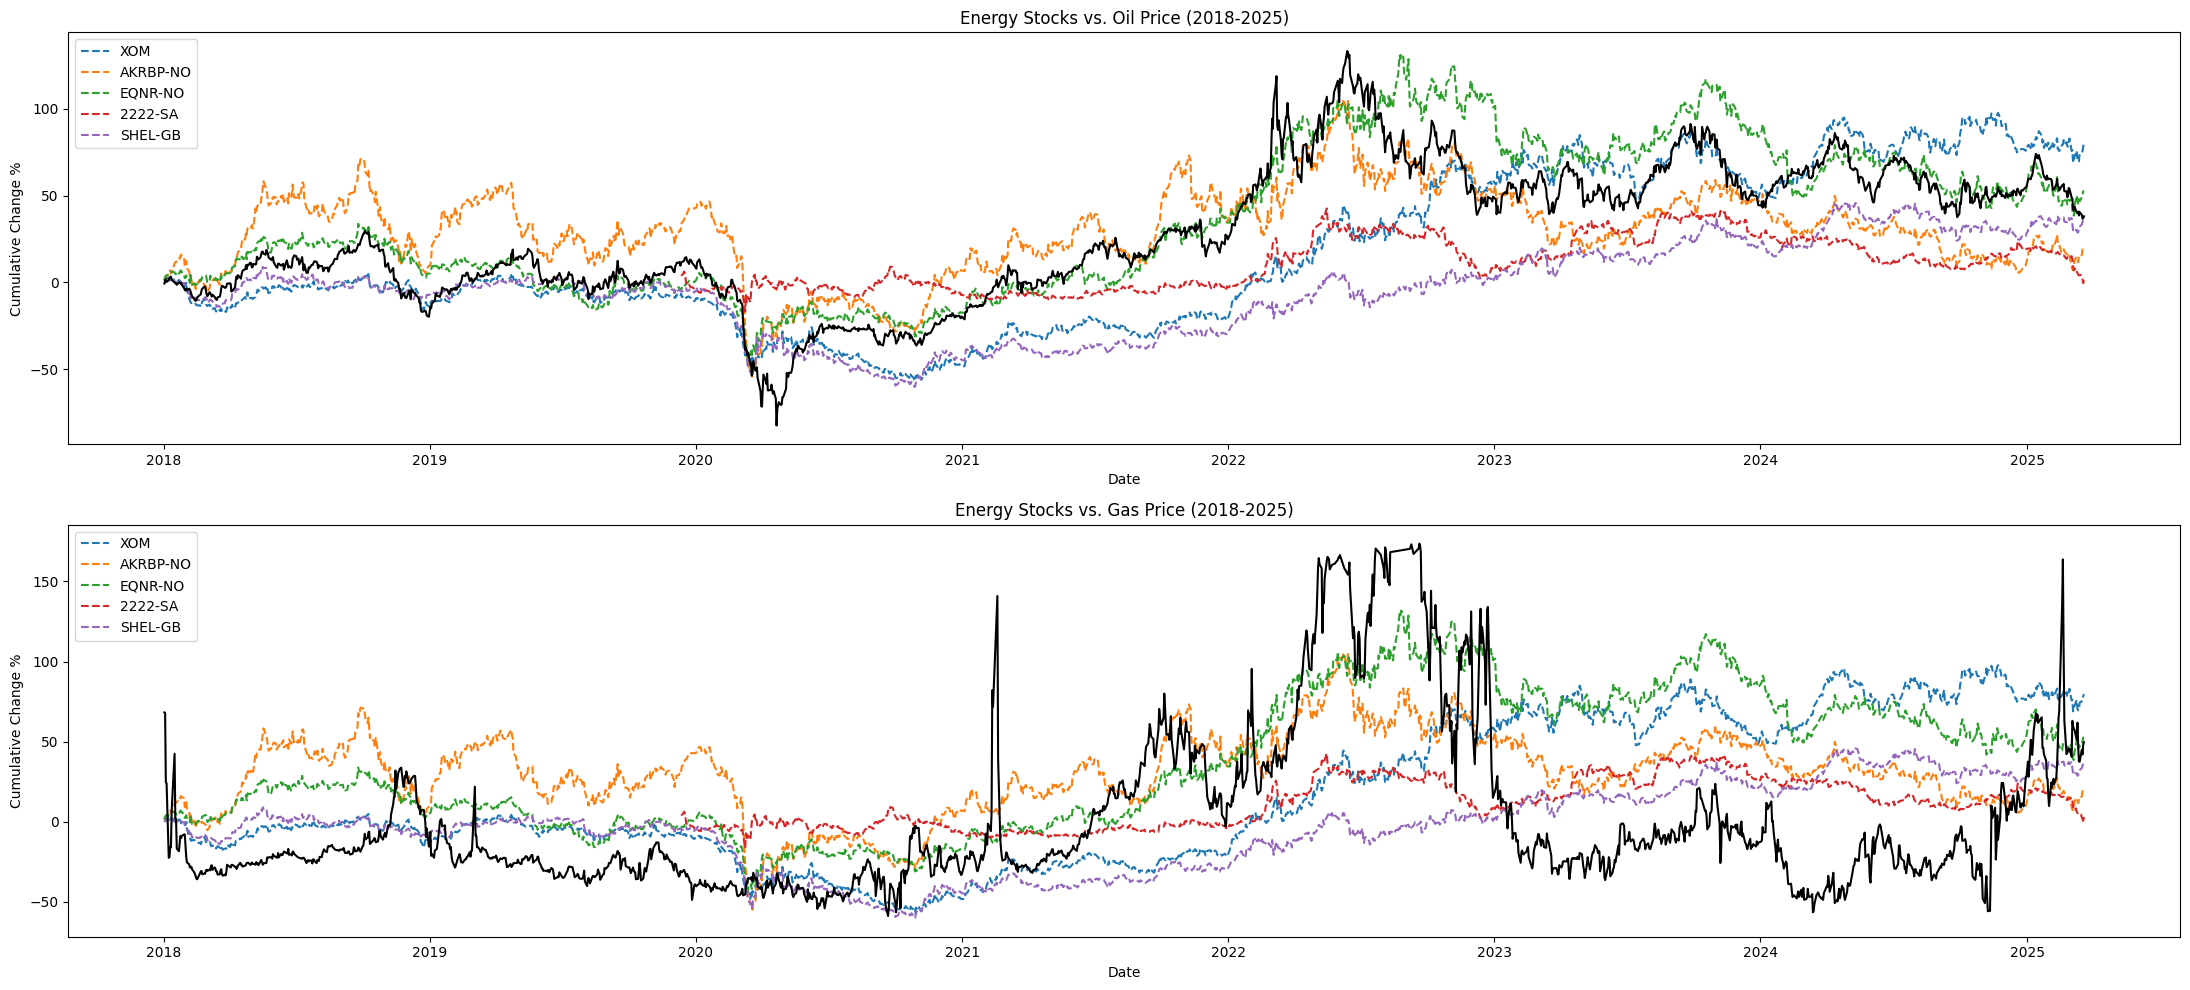

In [65]:
energy_stocks = ['EQNR-NO', 'AKRBP-NO', '2222-SA', 'SHEL-GB', 'XOM']
commodities = ['OILDB-FDS', 'HHGAS-FDS']

fig, axes = plt.subplots(2, 1, figsize=(22, 10))

sns.lineplot(data=df_stocks[df_stocks.Ticker.isin(energy_stocks)], x='Date', y='Cumulative Change %', hue='Ticker', ax=axes[0], linestyle='--')
sns.lineplot(data=df_commodities[df_commodities.Ticker == commodities[0]], x='Date', y='Cumulative Change %', ax=axes[0], color='black')   

q = df_commodities['Cumulative Change %'].quantile(0.99) # Quantile removal of outliers for improved plot clarity
sns.lineplot(data=df_stocks[df_stocks.Ticker.isin(energy_stocks)], x='Date', y='Cumulative Change %', hue='Ticker', ax=axes[1], linestyle='--')
sns.lineplot(data=df_commodities[(df_commodities.Ticker == commodities[1]) & (df_commodities['Cumulative Change %'] < q)], x='Date', y='Cumulative Change %', ax=axes[1], color='black')

axes[0].set_title('Energy Stocks vs. Oil Price (2018-2025)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Change %') 
axes[0].legend(loc='upper left')     
     
axes[1].set_title('Energy Stocks vs. Gas Price (2018-2025)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Change %') 
axes[1].legend(loc='upper left')     

plt.tight_layout()
plt.show()


As can be seen from the plot above, the stock prices of Norwegian energy companies seem to follow the fluctuations of the oil price. It will therefore be interesting to investigate whether the stock price has some explanatory power on the stock price.

### Correlation Analysis

In [66]:
df_stocks = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx', parse_dates=['Date'])
df_commodities = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx', parse_dates=['Date'])
df_exchange_rates = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx', parse_dates=['Date'])

pivot_stocks = df_stocks.pivot(index='Date', columns='Ticker', values='% Change').dropna().reset_index()
pivot_commodities = df_commodities.pivot(index='Date', columns='Ticker', values='% Change').dropna().reset_index()
pivot_exchange_rates = df_exchange_rates.pivot(index='Date', columns='Ticker', values='% Change')

corr_df = pivot_stocks.merge(pivot_commodities, how='inner', on='Date').merge(pivot_exchange_rates, how='inner', on='Date')

corr_df.sample(2)

Ticker       Date   2222-SA  AKRBP-NO    DNO-NO   DOFG-NO   EQNR-NO    KOG-NO  \
286    2025-02-27  0.509221  0.777874  2.684564  0.395257  1.509508 -1.609364   
290    2025-03-10 -1.868805  1.711277  2.291326 -3.446227  4.281467 -3.205128   

Ticker    NHY-NO   SHEL-GB    VAR-NO       XOM    YAR-NO  AECOCAD-FDS  \
286    -0.917975  0.528049 -0.311721  1.518728 -0.272975     2.810490   
290    -4.070595 -0.004407  0.130890  1.965965  0.873231    16.176679   

Ticker  HHGAS-FDS  OILDB-FDS   WTI-FDS    CHFNOK    EURNOK    GBPNOK    USDNOK  
286      1.141476   2.969367  3.446250  0.249021 -0.014994  0.338513  0.882799  
290     -4.193400  -2.503528 -2.017602 -0.868449 -0.866797 -0.723377 -0.569504

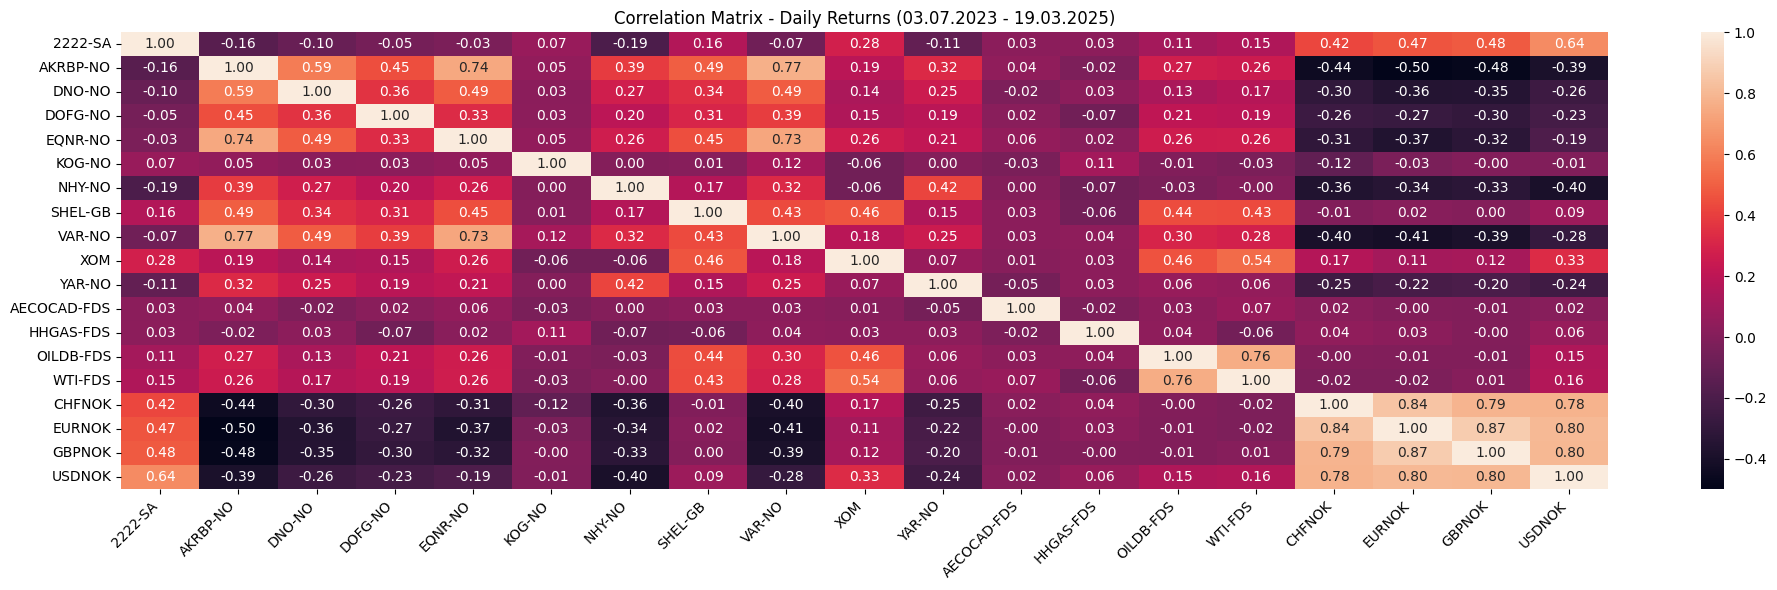

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select labels and date range
labels = [x for x in corr_df.columns if x != 'Date']
start_date = corr_df.iloc[0].Date.strftime('%d.%m.%Y')
end_date = corr_df.iloc[-1].Date.strftime('%d.%m.%Y')

# Compute the correlation matrix
corr_matrix = corr_df[labels].corr()

# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))  # slightly larger for readability
sns.heatmap(
    corr_matrix,
    annot=True,               # show the numbers
    fmt=".2f",                # round to 2 decimal places
    xticklabels=labels,
    yticklabels=labels,
    ax=ax
)

# Titles and layout
ax.set_title(f"Correlation Matrix - Daily Returns ({start_date} - {end_date})")
ax.set_xlabel('')
ax.set_ylabel('')

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


The correlation heatmap illustrates the relationships between daily returns of energy equities, oil & gas prices, and NOK currency pairs over the period from July 2023 to March 2025. Most Norwegian energy stocks (e.g., EQNR-NO, DNO-NO, AKRBP-NO, VAR-NO) show strong positive correlations with each other—particularly EQNR-NO and VAR-NO (0.77)—reflecting their shared exposure to global oil prices and the domestic economic environment. As expected, Kongsberg Gruppen (KOG-NO), which operates in defense and maritime technology, exhibits minimal correlation with the energy sector. Commodity price benchmarks, especially WTI (WTI-FDS) and OilDB-FDS, are moderately correlated with key energy stocks like XOM, SHEL-GB, and VAR-NO (≈0.4–0.5), consistent with their upstream exposure. Notably, the NOK crosses (CHFNOK, EURNOK, etc.) show strong positive inter-correlations and moderate negative correlation with oil equities, indicating a tendency for the NOK to strengthen with rising oil prices—a pattern in line with Norway’s status as a net oil exporter. USDNOK stands out with the highest positive correlation to oil, suggesting USD weakening (relative to NOK) when oil prices rise.

## Empirical Analysis

In this section we will describe how we performed our empirical analysis. As mentioned in the problem statement, we implemented two time-series models; the ARIMA and ARIMAX models. 

ARIMA (AutoRegressive Integrated Moving Average) is a time-series forecasting model that relies on past values of the target variable and errors to make predictions. It consists of three components: the AutoRegressive (AR) part, which incorporates past values of the series; the Integrated (I) part, which ensures stationarity through differencing; and the Moving Average (MA) part, which accounts for past forecast errors. Since ARIMA only considers the historical behavior of the target variable without any external influences, it is classified as a univariate model.

ARIMAX (ARIMA with Exogenous Variables) extends ARIMA by incorporating external factors that may influence the target variable. In addition to the AR, I, and MA components, ARIMAX includes exogenous variables (X), which help explain variations in the target series. By integrating external variables, ARIMAX becomes a multivariate model, improving forecasting accuracy if the chosen factors have significant predictive power.


In [68]:
def load_data(file_path, date_col='Date'):
    df = pd.read_excel(file_path, parse_dates=[date_col])
    perc_cols = [x for x in df.columns if '%' in x]
    
    for col in perc_cols:
        df[col] /= 100
        
    return df

df_stocks = load_data('Data/Processed/DAILY_STOCK_PRICES.xlsx')
df_commodities = load_data('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')
df_exchange_rates = load_data('Data/Processed/DAILY_EXCHANGE_RATES.xlsx') 

start_date = datetime(2015, 1, 1)
cols = ['Date', 'Ticker', '% Change']

features_stocks = df_stocks[df_stocks.Date >= start_date][cols].rename(columns={'% Change': 'StockPriceChange'}).copy()
features_commodities = df_commodities[
        (df_commodities.Date >= start_date) & 
        (df_commodities.Ticker.isin(['HHGAS-FDS', 'OILDB-FDS']))
    ][cols]\
    .pivot(index='Date', columns='Ticker', values='% Change')\
    .reset_index()   
    
features_currencies = df_exchange_rates[df_exchange_rates.Date >= start_date].groupby("Date").agg(daily_mean=pd.NamedAgg("% Change", "mean")).reset_index().rename(columns={'daily_mean': 'MeanExchangeRate'})
features_full = features_stocks.merge(features_commodities, on='Date', how='left').merge(features_currencies, on='Date', how='left').dropna()

features_full.sample(5)

Date   Ticker  StockPriceChange  HHGAS-FDS  OILDB-FDS  \
10411 2023-11-14   NHY-NO          0.034586   0.014102  -0.014770   
13710 2024-08-20  2222-SA         -0.011246   0.022118  -0.033471   
3534  2024-11-27      XOM         -0.013309   0.051315  -0.019334   
16777 2024-09-30  DOFG-NO          0.020384   0.051985   0.014444   
2537  2020-12-10      XOM          0.021360  -0.006721   0.024211   

       MeanExchangeRate  
10411         -0.005780  
13710         -0.002291  
3534          -0.004473  
16777          0.003569  
2537          -0.007240

### Test for stationarity

A crucial assumption of the ARIMA models is stationarity. A stationary process is a time series whose statistical properties, such as mean, variance and autocorrelation are constant over time (Brooks pg.248). The behavior of the series is independent of when one observes it. 

There are several reasons for why stationarity is desirable. Firstly, shocks may persist infinitely in a non-stationary process. Random disturbances may cause permanent shifts in the series, making it difficult for models that assume mean-reverting properties to predict future values. Additionally, two non-stationary series can move together over time, producing artificially high $R^2$ despite having no true relationship. This effect is called spurious regressions and can result from trending behavior misinterpreted as correlation. Lastly, non-stationary data can cause the t-ratios to not follow a t distribution, making hypothesis testing about the regression parameters less reliable (Brooks pg.334-336). 

Since ARIMA relies on data being stationary, tests to detect non-stationarity are conducted. The Augmented Dicky-Fuller (ADF) Test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests are two statistical methods to investigate stationarity (Brooks pg. 347). This project will use both ADF and KPSS, as they test opposite things, and thus complement each other. The null hypothesis of ADF is that the time series is non-stationary, while KPSS’s null hypothesis is that the time series is stationary.

Both of these tests are pre-implemented in the Statsmodels package in Python. Note that the tests are conducted with a significane level of 5%, which is deemed to be industry standard. Before we conduct the stationarity tests, the datasets columns are renamed to ease data manipulation. Additionally, a dictionary is created to store data and results. 

#### Check stationarity of prices
Prices are known to potentially be non-stationary and follow a trend or drift. To confirm this, ADF and KPSS test are run on all stock and commodities prices, as well as exchange rate values.  

In [69]:
def stationarity_check(df, type, col):
    tickers = df.Ticker.unique()
    
    results = []
    for ticker in tickers:
        warnings.filterwarnings("ignore")  # Suppress KPSS warnings
        series = df[df.Ticker == ticker][col].to_numpy()
        
        adf_result = adfuller(series)
        kpss_result = kpss(series, regression='c', nlags='auto')
        
        # Interpretation of results
        conclusion = 'error'
        
        # Clear cases
        if adf_result[1] < 0.05 and kpss_result[1] > 0.05: #ADF reject null: shows stationary, KPSS fail to reject null: shows stationary
            conclusion = 'Stationary'
            
        elif adf_result[1] > 0.05 and kpss_result[1] < 0.05: #ADF fail to reject null: shows non-stationary, KPSS reject null: shows non-stationary
            conclusion = 'Non-Stationary'
           
        # Unclear cases, conflicting results
        elif adf_result[1] < 0.05 and kpss_result[1] < 0.05: #ADF reject null: shows stationary, KPSS reject null: shows non-stationary
            conclusion = 'Conflicting Results: only KPSS flags non-statio'
         
        elif adf_result[1] > 0.05 and kpss_result[1] > 0.05: #ADF fail to reject null: shows non-stationary, KPSS fail to reject null: shows stationary
            conclusion = 'Conflicting Results: only ADF shows non-statio'
        
        results.append({
            'type': type,
            'ticker': ticker,       
            'ADF Statistic': round(adf_result[0], 4),
            'ADF p-value': round(adf_result[1], 4),
            'KPSS Statistic': round(kpss_result[0], 4),
            'KPSS p-value': round(kpss_result[1], 4),
            'Conclusion': conclusion
        })
    
    return pd.DataFrame(results)

In [70]:
col = 'Price'
test1 = stationarity_check(df_stocks, 'Stock', col)
test2 = stationarity_check(df_commodities, 'Commodity', col)
test3 = stationarity_check(df_exchange_rates, 'Exchange Rate', 'Mid')
test_results = pd.concat([test1, test2, test3], ignore_index=True)      

display(test_results)

type       ticker  ADF Statistic  ADF p-value  KPSS Statistic  \
0           Stock       YAR-NO        -2.5635       0.1008          1.3081   
1           Stock          XOM        -0.3183       0.9229          4.6831   
2           Stock       KOG-NO         5.4136       1.0000          4.7934   
3           Stock       DNO-NO        -2.0910       0.2482          0.8110   
4           Stock     AKRBP-NO        -3.0642       0.0293          0.8421   
5           Stock       NHY-NO        -1.3197       0.6201          3.7579   
6           Stock      EQNR-NO        -1.1690       0.6868          4.0076   
7           Stock      2222-SA        -1.7391       0.4111          3.4286   
8           Stock       VAR-NO        -2.8902       0.0465          0.5431   
9           Stock      SHEL-GB        -0.6516       0.8589          3.0010   
10          Stock      DOFG-NO        -1.6626       0.4505          2.9070   
11      Commodity    HHGAS-FDS        -2.8930       0.0462          1.0780   
12      Commodity    OILDB-FDS        -1.9924       0.2899          3.9333   
13      Commodity  AECOCAD-FDS        -2.3878       0.1452          1.5877   
14      Commodity      WTI-FDS        -1.7562       0.4024          4.2338   
15  Exchange Rate       CHFNOK        -1.0405       0.7382          5.8669   
16  Exchange Rate       USDNOK        -1.6811       0.4409          5.1497   
17  Exchange Rate       GBPNOK        -1.2936       0.6321          5.4448   
18  Exchange Rate       EURNOK        -1.5994       0.4839          4.6498   

    KPSS p-value                                       Conclusion  
0         0.0100                                   Non-Stationary  
1         0.0100                                   Non-Stationary  
2         0.0100                                   Non-Stationary  
3         0.0100                                   Non-Stationary  
4         0.0100  Conflicting Results: only KPSS flags non-statio  
5         0.0100                                   Non-Stationary  
6         0.0100                                   Non-Stationary  
7         0.0100                                   Non-Stationary  
8         0.0319  Conflicting Results: only KPSS flags non-statio  
9         0.0100                                   Non-Stationary  
10        0.0100                                   Non-Stationary  
11        0.0100  Conflicting Results: only KPSS flags non-statio  
12        0.0100                                   Non-Stationary  
13        0.0100                                   Non-Stationary  
14        0.0100                                   Non-Stationary  
15        0.0100                                   Non-Stationary  
16        0.0100                                   Non-Stationary  
17        0.0100                                   Non-Stationary  
18        0.0100                                   Non-Stationary

As expected, most of these prices and values are non-stationary, and cannot be used as input to an ARIMA model. Interestingly, the stock prices of AkerBP (AKERBP-NO) and Vår Energi (VAR-NO), as well as the commodity price of Natural gas (HHGAS-FDS) show signs of stationarity, with the ADF test and KPSS test returning conflicting results. This can be due to the prices of these tickers having a relatively stable trend.

#### Check stationarity of returns

Next, stock returns are investigated for non-stationarity. 

In [71]:
col = '% Change'
test1 = stationarity_check(df_stocks, 'Stock', col)
test2 = stationarity_check(df_commodities, 'Commodity', col)
test3 = stationarity_check(df_exchange_rates, 'Exchange Rate', col)
test_results = pd.concat([test1, test2, test3], ignore_index=True)      

display(test_results)

type       ticker  ADF Statistic  ADF p-value  KPSS Statistic  \
0           Stock       YAR-NO       -43.4718          0.0          0.0507   
1           Stock          XOM       -15.0318          0.0          0.2654   
2           Stock       KOG-NO       -28.4247          0.0          0.4415   
3           Stock       DNO-NO       -15.6698          0.0          0.0588   
4           Stock     AKRBP-NO       -14.1370          0.0          0.0524   
5           Stock       NHY-NO       -31.4349          0.0          0.2150   
6           Stock      EQNR-NO        -8.8338          0.0          0.1126   
7           Stock      2222-SA       -36.0341          0.0          0.1285   
8           Stock       VAR-NO       -17.1862          0.0          0.0855   
9           Stock      SHEL-GB       -14.8367          0.0          0.1895   
10          Stock      DOFG-NO       -21.4913          0.0          0.3366   
11      Commodity    HHGAS-FDS       -14.9095          0.0          0.1666   
12      Commodity    OILDB-FDS        -7.7811          0.0          0.0749   
13      Commodity  AECOCAD-FDS       -26.7508          0.0          0.1443   
14      Commodity      WTI-FDS        -9.0180          0.0          0.0337   
15  Exchange Rate       CHFNOK       -44.7332          0.0          0.0389   
16  Exchange Rate       USDNOK       -42.1520          0.0          0.0303   
17  Exchange Rate       GBPNOK       -47.9343          0.0          0.0346   
18  Exchange Rate       EURNOK       -29.9198          0.0          0.0355   

    KPSS p-value  Conclusion  
0         0.1000  Stationary  
1         0.1000  Stationary  
2         0.0593  Stationary  
3         0.1000  Stationary  
4         0.1000  Stationary  
5         0.1000  Stationary  
6         0.1000  Stationary  
7         0.1000  Stationary  
8         0.1000  Stationary  
9         0.1000  Stationary  
10        0.1000  Stationary  
11        0.1000  Stationary  
12        0.1000  Stationary  
13        0.1000  Stationary  
14        0.1000  Stationary  
15        0.1000  Stationary  
16        0.1000  Stationary  
17        0.1000  Stationary  
18        0.1000  Stationary

Importantly, as seen in the output above, all returns are confirmed to be stationary, which is to be expected. To satisfy ARIMA's stationarity requirement, returns will be used for modelling.

### Forecasting with ARIMA

After preprocessing the data, and confirming stationarity, we can now proceed with ARIMA modelling. The ARIMA model will be the baseline model of this project to investigate whether including external factors such as oil return or change in currency rates can help improve stock return predictions. 

#### Divide data into training and test sets

For forecasting, dividing the data into training and test data is essential. It is important that the model is not evaluated on data which it already has seen, as this can lead to unrealistically high model performance. Therefore, it is common to hold out some data for testing, called a holdout sample (Brooks, pg.278). There are several ways to construct a holdout sample. The simplest way to achieve this is to use the first 80% of the data as training data, while the last 20% is used as test data. This is done below.

Note that since we split on number of rows, and not date, each ticker may have training and test windows with different start and end date.

In [72]:
tickers = features_full.Ticker.unique() 

def split_data(data, ticker, test_size=100, target_col='StockPriceChange'):
    df = data[data.Ticker == ticker].drop(columns=['Ticker'])
    
    test_dates = df.Date.iloc[-test_size:]
    df.sort_values(by='Date', inplace=True)
    df.drop(columns=['Date'], inplace=True)
    
    train = df.iloc[:-test_size]
    test = df.iloc[-test_size:]
    
    y_train = train[target_col]
    y_test = test[target_col]
    
    exo_cols = df.columns[df.columns != target_col]
    X_train = train[exo_cols]
    X_test = test[exo_cols]
    
    return {
        'test_dates': test_dates,
        'y_train': y_train,
        'y_test': y_test,
        'X_train': X_train,
        'X_test': X_test      
    }

ticker_data = [(x, split_data(features_full, x)) for x in tickers]

#### Finding optimal ARIMA parameters

To implement an ARIMA model, the Box-Jenkins Approach was used (Brooks, pg.269). The first step of this approach consists in identifying the order of the model required to accurately capture the relationships of the data. With the use of returns, stationarity is insured and no differencing is needed. Therefore, the parameter d=0 and the ARIMA model reduces to an ARMA model. As this project focuses on stock prediction, ARMA models for stocks only will be implemented. For each stock, the parameters p (capturing the underlying autoregressive processes) and q (capturing the underlying moving average processes) are estimated using a grid search. To find a compromise between runtime and accuracy, the grid search is chosen to be of size 5*5. The information criteria AIC can be used to model find the optimal ARIMA paramters. 


In [73]:
from tqdm import tqdm

def arima_parameter_search(y_train):
    aic_results = [] 
    for p in range(5):
        for q in range(5):
            try:
                model = ARIMA(y_train, order=(p, 0, q)).fit()
                aic_results.append((p, q, model.aic))
            except Exception as e:
                print(f"Error with parameters (p={p}, d=0, q={q}): {e}")    
                continue
    best_aic = sorted(aic_results, key=lambda x: x[2])[0]
    return best_aic[0], best_aic[1]

result_stock = []
for ticker, data in tqdm(ticker_data, desc="Processing stocks"):
    p_aic, q_aic= arima_parameter_search(data['y_train'])
    result_stock.append({
        'Type': 'Stock',
        'Ticker': ticker,
        'AIC_parameters': (p_aic, 0, q_aic),
    })
    
result_stock_df = pd.DataFrame(result_stock)
display(result_stock_df)
print()

Processing stocks: 100%|██████████| 11/11 [01:53<00:00, 10.32s/it]


Type    Ticker AIC_parameters
0   Stock    YAR-NO      (0, 0, 0)
1   Stock       XOM      (4, 0, 4)
2   Stock    KOG-NO      (0, 0, 0)
3   Stock    DNO-NO      (3, 0, 4)
4   Stock  AKRBP-NO      (2, 0, 4)
5   Stock    NHY-NO      (0, 0, 0)
6   Stock   EQNR-NO      (4, 0, 4)
7   Stock   2222-SA      (0, 0, 0)
8   Stock    VAR-NO      (0, 0, 4)
9   Stock   SHEL-GB      (2, 0, 0)
10  Stock   DOFG-NO      (0, 0, 0)

In [74]:
stock_order = result_stock_df[['Ticker', 'AIC_parameters']].set_index('Ticker').to_dict()['AIC_parameters']

The above output shows the optimal parameters found for each stock. It is to be noted that for some stocks the optimal parameters are found to be (0,0,0). This corresponds to the most basic model, just a white noise process. The predictions with an ARIMA(0,0,0) model will simply be the mean. The time series for these stocks may not have any significant autocorrelation. This is to be expected, as daily stock returns act as white noise. Additionally, this highlights the need for exploring more complex models such as ARIMAX, which also include the factors of external variables. Nevertheless, when considering AIC, 9 out of 11 stocks do have non-zero model parameters, highlighting the potential usefulness of predicting stocks using autocorrelation information and ARMA.

#### Fitting the model

The second step of the Box-Jenkins approach involves fitting the ARMA model with the parameters found in the previous step. Firstly, a one-shot-prediction model is fitted. For each stock, a ARMA model is trained on the first 80% of the time series. The obtained model is then used to predict the last 20% of the data all at once. This means that the first datapoint in the testset is predicted using the same model as the last datapoint in the testset, ignoring the behavior of the stock in between. 

Below the code for a one-shot-prediction, as well as plots showing the forecasts, are presented.

 

In [75]:
from tqdm import tqdm

def evaluate_arima_models(ticker_data, stock_order):
    results = []
    for ticker, split in tqdm(ticker_data, desc='Processing stocks'):
        y_train = split['y_train']
        y_test = split['y_test']
        
        # Fit the model
        model_aic = ARIMA(y_train, order=stock_order.get(ticker)).fit()
        aic_forecast = model_aic.forecast(steps=y_test.shape[0])
        
        # Evaluate RMSE, sign and flip accuracy
        aic_rmse = np.sqrt(mean_squared_error(y_test, aic_forecast))        
        sign_accuracy = np.mean(np.sign(y_test.values) == np.sign(aic_forecast.values))    

        actual_flips = np.sign(y_test.values[:-1]) != np.sign(y_test.values[1:])
        pred_flips = np.sign(aic_forecast.values[:-1]) != np.sign(aic_forecast.values[1:])
        correct_flips = actual_flips == pred_flips
        flip_accuracy = np.mean(correct_flips)
        
        # Store results
        results.append({
            'Ticker': ticker,
            'dates': split['test_dates'],
            'y_true': y_test,
            'y_pred': aic_forecast,
            'AIC_RMSE': aic_rmse,
            'AIC_sign_accuracy': sign_accuracy,
            'AIC_flip_accuracy': flip_accuracy
        })
    
    return results

arima_oneshot_results = evaluate_arima_models(ticker_data, stock_order)

Processing stocks: 100%|██████████| 11/11 [00:07<00:00,  1.57it/s]


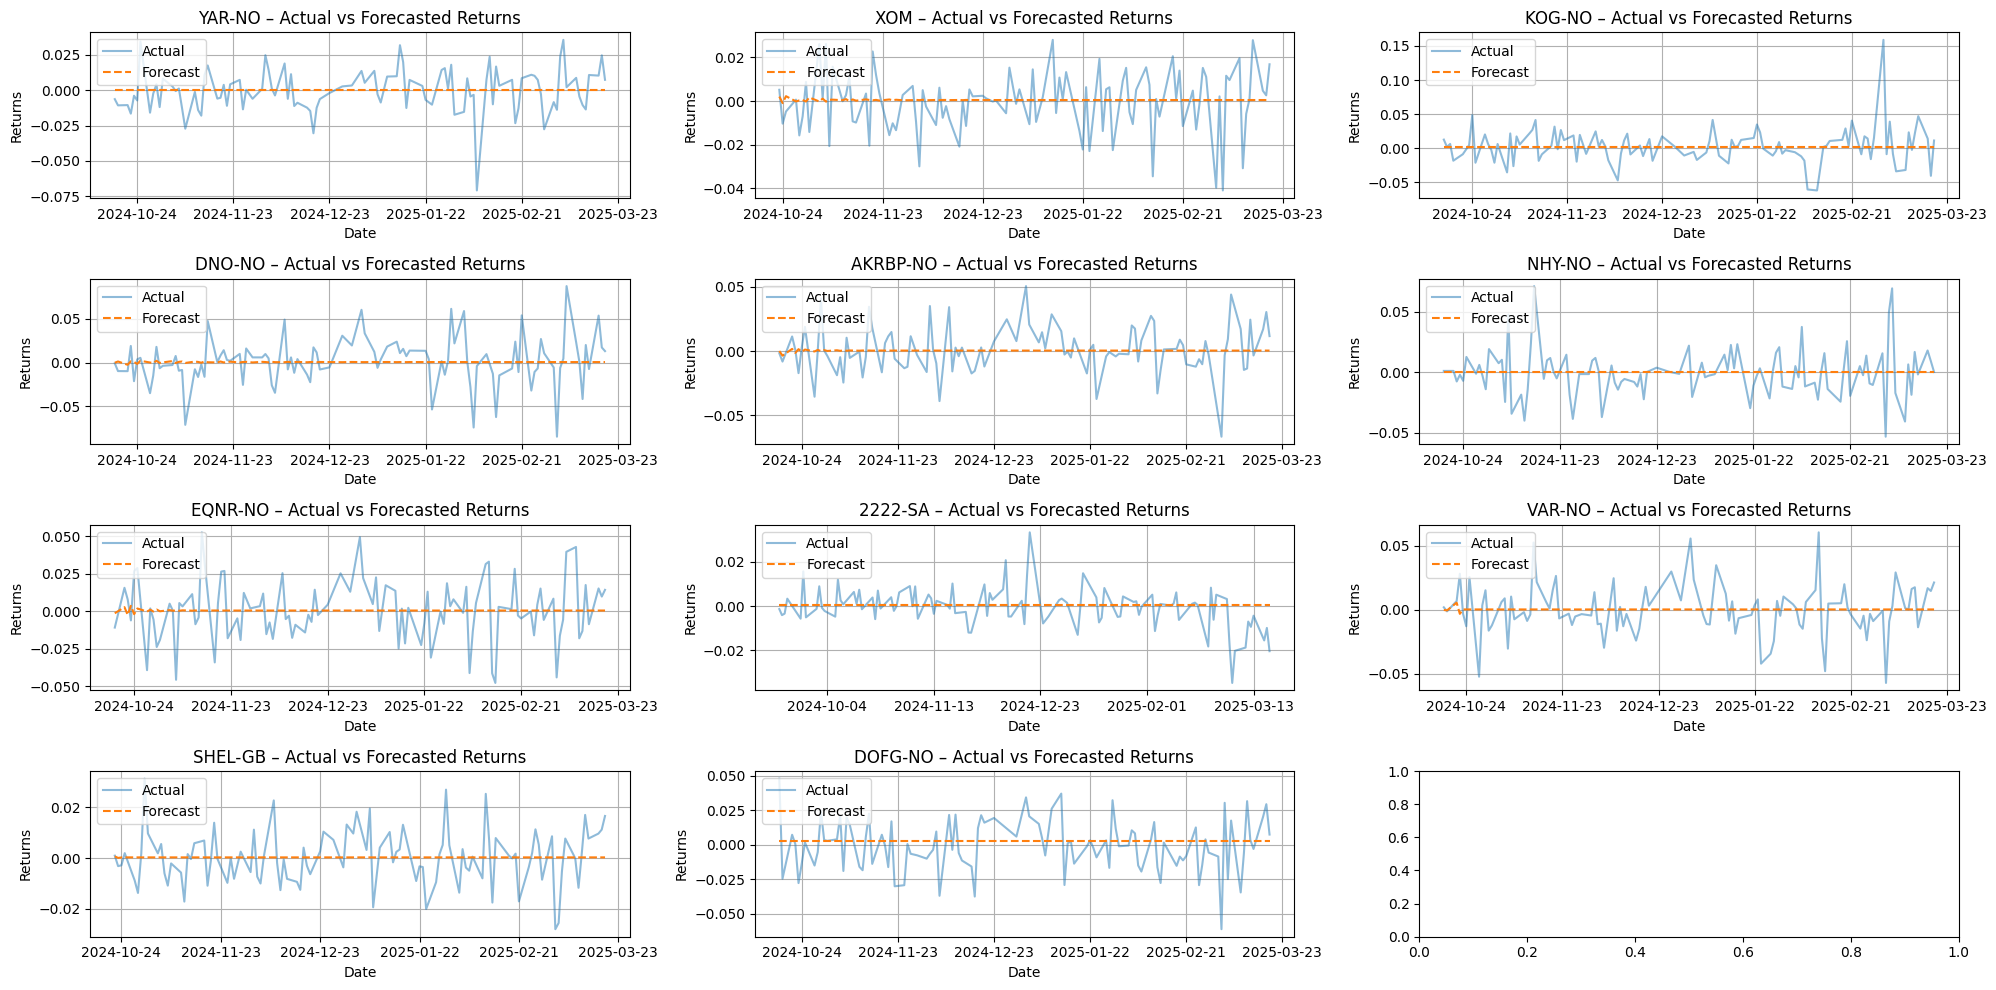

In [76]:
def plot_forecasts(results):
    fig, axes = plt.subplots(4, 3, figsize=(20, 10))
    
    for i, res in enumerate(results):
        test_dates = res['dates']
        y_true = res['y_true']
        y_pred = res['y_pred']

        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        ax.plot(test_dates, y_true, label='Actual', alpha=0.5)
        ax.plot(test_dates, y_pred, label='Forecast', linestyle='--')
        ax.set_title(f"{res['Ticker']} – Actual vs Forecasted Returns")
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        ax.legend(loc='upper left')
        ax.grid(True)
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Limit to 6 x-ticks

    plt.tight_layout()
    plt.show()

plot_forecasts(arima_oneshot_results)

The plots above show that the predictions, at least visually, are not very good. While the predictions somewhat follow the stock return for the first few days, they quickly converge towards the mean return. As daily stock returns usually resemble white noise processes, the mean is expected to be around zero, causing flat predictions. For the ARMA(0,0) processes, the stock price is constantly predicted to be around the mean. These insights highlight the limitation of one-short forecasting with ARMA models. These models are short-memory processes, mainly capturing autocorrelation over recent lags. Therefore, they are inappropriate for forecasting predictions well into the future without updating the model.
 
The one-off prediction ARMA model is just a baseline model. A more in-depth evaluation of later models will follow in the section "Evaluating the Model". For now, the model is solely evaluated visually.

#### Rolling window predictions

The poor performance of the one-shot-prediction ARMA models motivate the use of rolling training windows, where the model both is continuously updated with new data and solely focuses on short-term forecasting. This model fitting strategy leverages the properties of ARMA models in a better way. 

The rolling window prediction is constructed in the following way. The window-size is set to 100, which means that all ARMA models are fitted based on 100 days of past stock returns. Each ARMA model is used to only predict the next days’ stock returns. The first prediction, for example, is obtained by fitting an ARMA model on the first 100 days of stock returns, and then predicting the stock return of the 101st day of the dataset. To predict the stock return of day 102, the window is shifted forwards by one day. A new ARMA model is fitted on the stock returns from day 1 to day 101, and used to predict the stock return on day 102. This process continues until stock returns for all days, excluding the first 100 days (the first window), are predicted. As seen in the plots, this approach captures the movement of the stock returns in much higher accuracy, over the whole period of the time series. 

Below a function is created to implement a rolling ARIMA model. To ensure code reproducibility, the below function also already supports ARIMAX integration. The plots below show the visual results of the forecasts. Note that the code has a long run time, around 20 minutes on our PCs. 



In [77]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def single_arima_rw(y_train, y_test, order, window_size):
    history = list(y_train.values)
    predictions = []
    
    for t in range(y_test.shape[0]):
        model = ARIMA(history[-window_size:], order=order).fit()
        y_pred = model.forecast(steps=1)[0]
        predictions.append(y_pred)
        history.append(y_test.iloc[t])        
    
    return predictions

def process_ticker(ticker, split, stock_order, window_size):
    """
    Process a single ticker using the rolling ARIMA forecasting.
    Computes forecasts and evaluation metrics.
    """
    order = stock_order.get(ticker)
    y_train = split['y_train']
    y_test = split['y_test']
    
    # Get forecasts from the rolling ARIMA procedure
    y_pred = single_arima_rw(y_train, y_test, order, window_size) 
    
    # Evaluate RMSE, sign accuracy, and flip accuracy
    aic_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    sign_accuracy = np.mean(np.sign(y_test.values) == np.sign(y_pred))
    
    actual_flips = np.sign(y_test.values[:-1]) != np.sign(y_test.values[1:])
    pred_flips = np.sign(y_pred[:-1]) != np.sign(y_pred[1:])
    correct_flips = actual_flips == pred_flips
    flip_accuracy = np.mean(correct_flips)
    
    return {
        'Ticker': ticker,
        'dates': split['test_dates'],
        'y_true': y_test,
        'y_pred': y_pred,
        'AIC_RMSE': aic_rmse,
        'AIC_sign_accuracy': sign_accuracy,
        'AIC_flip_accuracy': flip_accuracy
    }

def evaluate_arima_rw(ticker_data, stock_order, window_size=100, num_threads=4):
    """
    Evaluate ARIMA rolling window forecasts concurrently using multithreading.
    """
    results = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Submit a job for each ticker and keep track of futures.
        future_to_ticker = {
            executor.submit(process_ticker, ticker, split, stock_order, window_size): ticker
            for ticker, split in ticker_data
        }
        
        for future in tqdm(as_completed(future_to_ticker), total=len(future_to_ticker), desc='Processing stocks'):
            try:
                result = future.result()
                results.append(result)
            except Exception as exc:
                ticker = future_to_ticker[future]
                print(f"Ticker {ticker} generated an exception: {exc}")
                
    return results


arima_rw_results = evaluate_arima_rw(ticker_data, stock_order, num_threads=16)

Processing stocks: 100%|██████████| 11/11 [02:24<00:00, 13.17s/it]


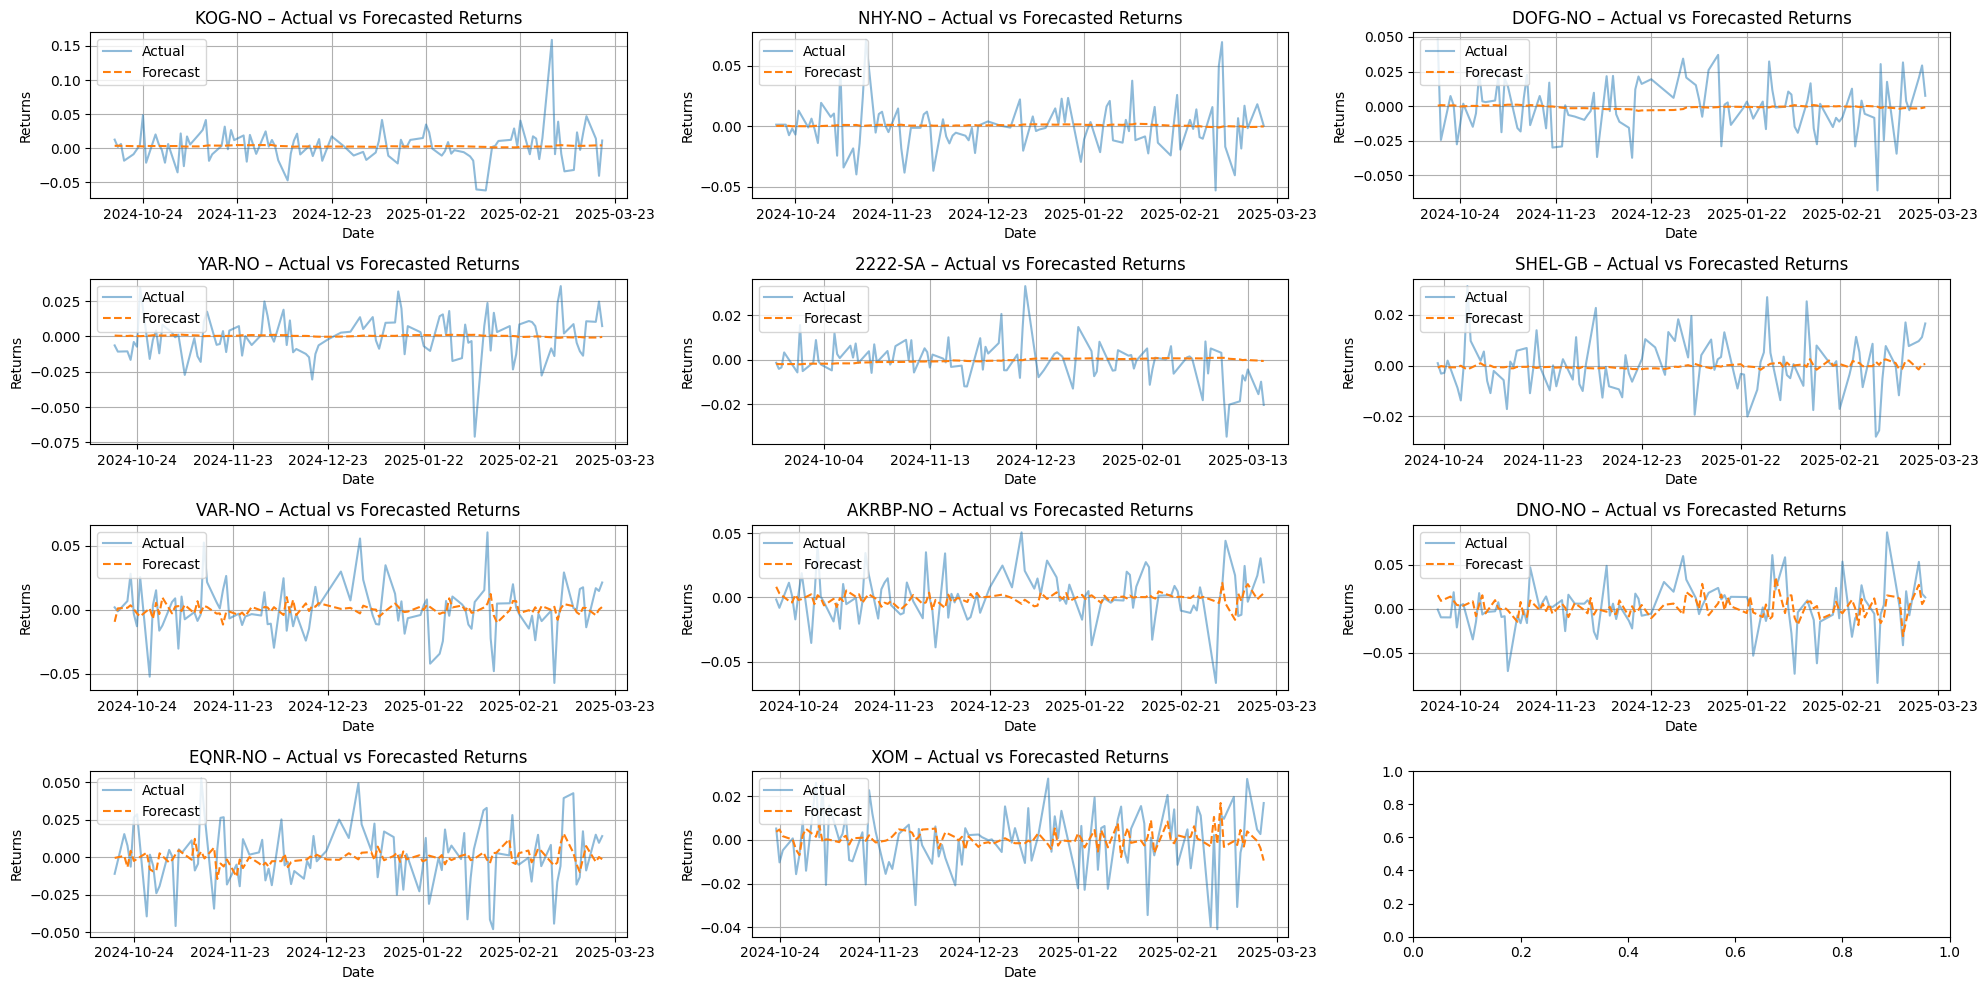

In [78]:
plot_forecasts(arima_rw_results)

In [79]:
columns = ['Ticker', 'AIC_RMSE', 'AIC_sign_accuracy', 'AIC_flip_accuracy']

arima_os = pd.DataFrame(arima_oneshot_results)[columns]
arima_os.columns = ['Ticker'] + ["ARIMA_OneShot_" + x.replace('AIC_', '') for x in arima_os.columns if x != 'Ticker']

arima_rw = pd.DataFrame(arima_rw_results)[columns]
arima_rw.columns = ['Ticker'] + ["ARIMA_RollingWindow_" + x.replace('AIC_', '') for x in arima_rw.columns if x != 'Ticker']

arima_results_df = arima_os.merge(arima_rw, on='Ticker', how='inner')
arima_results_df[['Ticker', 'ARIMA_OneShot_RMSE', 'ARIMA_RollingWindow_RMSE']]


Ticker  ARIMA_OneShot_RMSE  ARIMA_RollingWindow_RMSE
0     YAR-NO            0.015128                  0.015254
1        XOM            0.014253                  0.014234
2     KOG-NO            0.026360                  0.026323
3     DNO-NO            0.027143                  0.026867
4   AKRBP-NO            0.018240                  0.019112
5     NHY-NO            0.020208                  0.020335
6    EQNR-NO            0.020311                  0.020835
7    2222-SA            0.009090                  0.009246
8     VAR-NO            0.019879                  0.020361
9    SHEL-GB            0.010749                  0.010876
10   DOFG-NO            0.019088                  0.018959

Visually, the rolling-window method seemingly offers much better predictions. The plots show that the predictions seemigly follow the actual values more accuratly. Although rolling window forecasts often visually align more closely with the actual series, they may result in higher RMSE values compared to one-shot predictions. This can be observed in the table above. Rolling models are re-estimated at each step using the most recent data, allowing them to better adapt to short-term dynamics and potentially shifting patterns in the time series. They operate as we would expect in real life: predictions are made best on the newest available data. However, this flexibility may cause more sensitivity to noise, leading to higher RMSE. On the other hand, one-shot models, especially those with minimal structure like ARIMA(0,0,0), often predict the mean of the series, which minimizes RMSE but lacks any informative predictive power. As we are interested in realistic, adaptive forecasting, rolling forecasts offer more value. Brooks (2019, pg. 287) highlights the limitation of RMSE in measuring predictive power, and suggests other evaluation methods, discussed in section "Evaluating the Model". 


However, rolling predictions are way more computationally expensive than the one-shot predictions. Instead of fitting one ARMA model for each stock, each stock’s return is predicted using many ARMA models. In fact, a new ARMA model is fitted for every day, excluding the first 100 days of the time-series. This leads to much longer running times, with the whole prediction process taking 21 minutes in total for all stocks. 




#### ARIMAX prediction

In [80]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def single_arimax_rw(X_train, X_test, y_train, y_test, order, window_size):
    history = list(y_train.values)
    history_X = list(X_train.values)
    
    predictions = []
    
    for t in range(y_test.shape[0]):
        window_y = history[-window_size:]
        window_X = history_X[-window_size:]
        exog_forecast = X_test.iloc[t].values
        
        model = ARIMA(window_y, order=order, exog=window_X).fit()
        y_pred = model.forecast(steps=1, exog=exog_forecast)[0]
        
        predictions.append(y_pred)
        history.append(y_test.iloc[t])        
        history_X.append(exog_forecast)
    
    return predictions

def process_ticker_arimax(ticker, split, stock_order, window_size):
    """
    Process a single ticker using the rolling ARIMA forecasting.
    Computes forecasts and evaluation metrics.
    """
    order = stock_order.get(ticker)
    X_train = split['X_train']
    X_test = split['X_test']
    y_train = split['y_train']
    y_test = split['y_test']
    
    # Get forecasts from the rolling ARIMA procedure
    y_pred = single_arimax_rw(X_train, X_test, y_train, y_test, order, window_size) 
    
    # Evaluate RMSE, sign accuracy, and flip accuracy
    aic_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    sign_accuracy = np.mean(np.sign(y_test.values) == np.sign(y_pred))
    
    actual_flips = np.sign(y_test.values[:-1]) != np.sign(y_test.values[1:])
    pred_flips = np.sign(y_pred[:-1]) != np.sign(y_pred[1:])
    correct_flips = actual_flips == pred_flips
    flip_accuracy = np.mean(correct_flips)
    
    return {
        'Ticker': ticker,
        'dates': split['test_dates'],
        'y_true': y_test,
        'y_pred': y_pred,
        'AIC_RMSE': aic_rmse,
        'AIC_sign_accuracy': sign_accuracy,
        'AIC_flip_accuracy': flip_accuracy
    }

def evaluate_arimax_rw(ticker_data, stock_order, window_size=100, num_threads=4):
    """
    Evaluate ARIMA rolling window forecasts concurrently using multithreading.
    """
    results = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Submit a job for each ticker and keep track of futures.
        future_to_ticker = {
            executor.submit(process_ticker_arimax, ticker, split, stock_order, window_size): ticker
            for ticker, split in ticker_data
        }
        
        for future in tqdm(as_completed(future_to_ticker), total=len(future_to_ticker), desc='Processing stocks'):
            try:
                result = future.result()
                results.append(result)
            except Exception as exc:
                ticker = future_to_ticker[future]
                print(f"Ticker {ticker} generated an exception: {exc}")
                
    return results

arimax_rw_results = evaluate_arimax_rw(ticker_data, stock_order, num_threads=16)

Processing stocks: 100%|██████████| 11/11 [03:38<00:00, 19.84s/it]


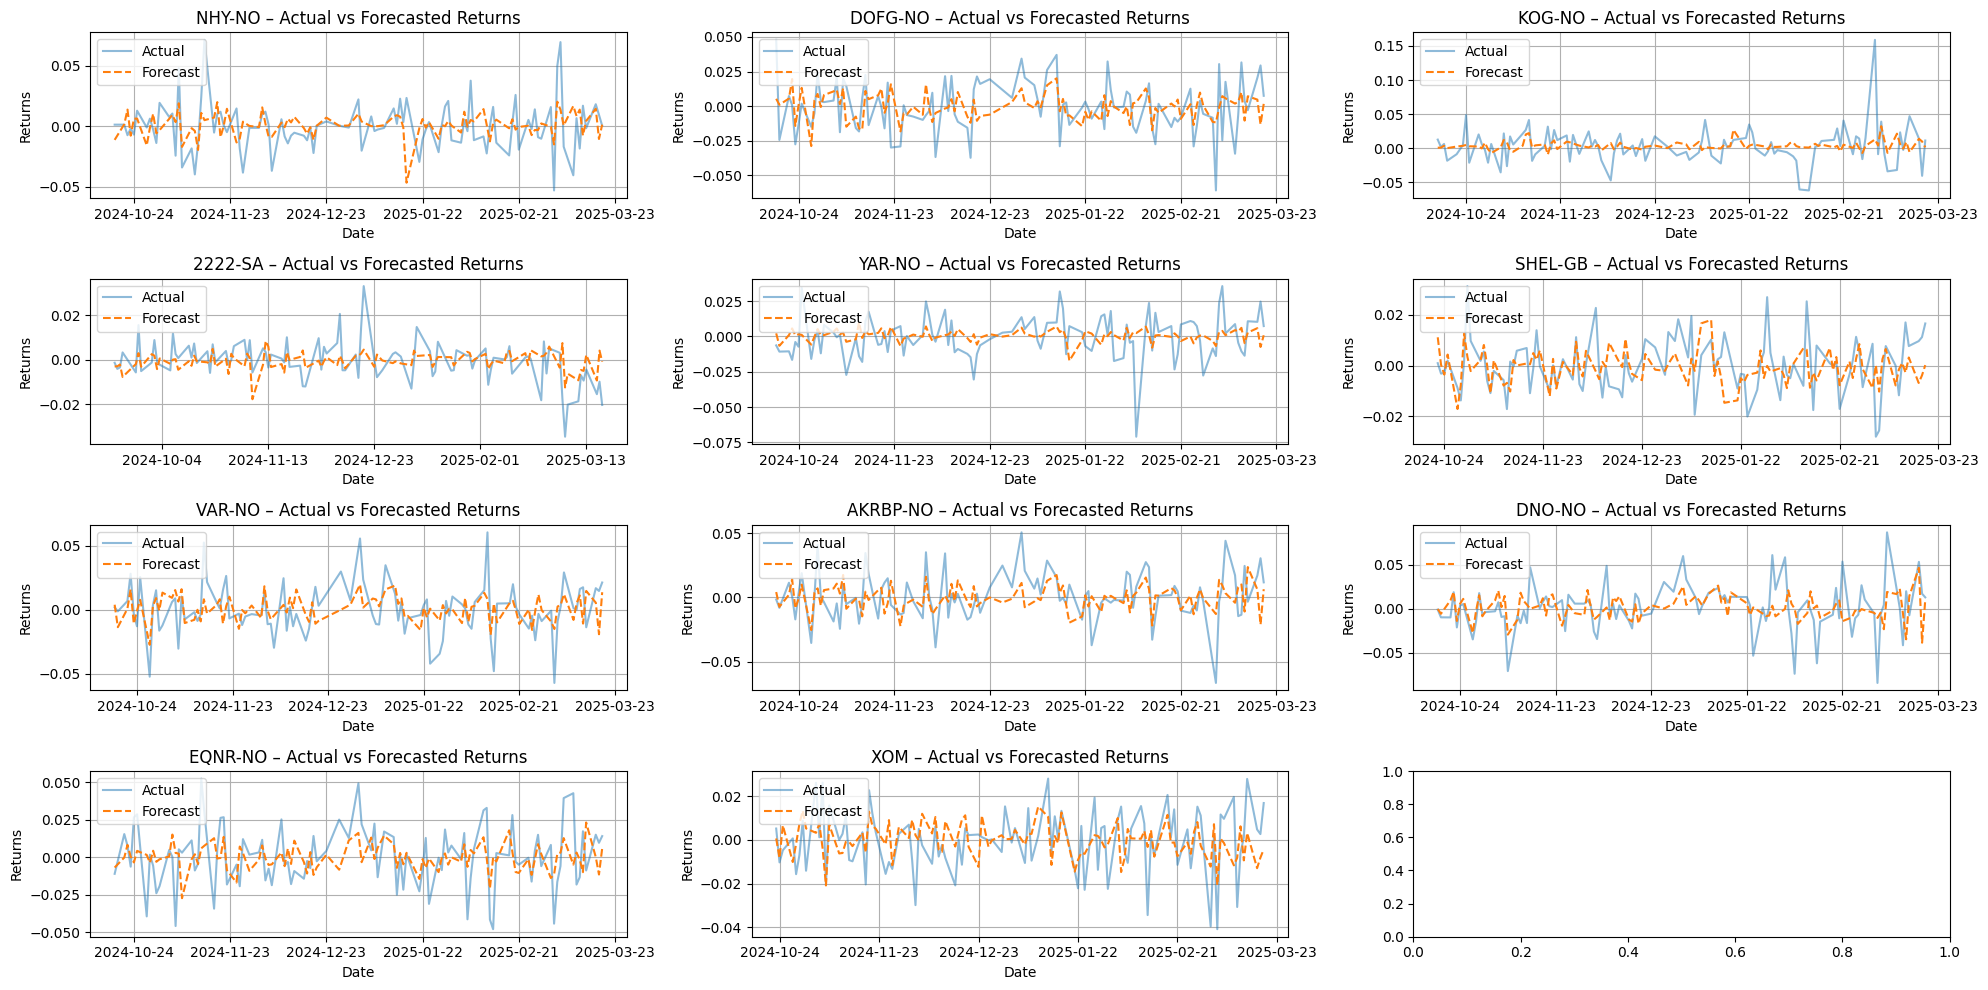

In [81]:
plot_forecasts(arimax_rw_results)

#### Evaluating the Model


Up until now, the model’s have largely been evaluated on a visual basis. However, it is essential to define metrics which quantify how accurate a prediction is. This can be done using the Root Mean Squared Error (RMSE) metric, which is common to use in prediction evaluation. The advantage of RMSE compared to MSE is that it is in the same unit as the original data. For financial forecasting, however, it may be more appropriate to use metrics which capture how well a model predicts the sign of future return or turning points in a series (Books, pg.287). Imagine the actual return being 3%, and we have two different predictions to evaluate: -2% and 9%. RMSE would prefer the first prediction, as it is numerically closer to the actual return.

However, in a financial context, the +9% prediction may be more useful, as it correctly predicts a positive return, potentially leading to the right trading decision. Therefore, this project also used share of correctly predicted signs of future returns and correctly predicted turning points as an evaluation metric. This is already implemented in the evaluate_arima_arimax_rolling function above.

Below follows a summary comparing the various model's performances.

In [ ]:
arimax_rw = pd.DataFrame(arimax_rw_results)[columns]
arimax_rw.columns = ['Ticker'] + ["ARIMAX_RollingWindow_" + x.replace('AIC_', '') for x in arima_rw.columns if x != 'Ticker']

arima_final_results = arima_results_df.merge(arimax_rw, on='Ticker', how='inner')

arima_final_results

Ticker  ARIMA_OneShot_RMSE  ARIMA_OneShot_sign_accuracy  \
0     YAR-NO            0.015128                         0.50   
1        XOM            0.014253                         0.52   
2     KOG-NO            0.026360                         0.57   
3     DNO-NO            0.027143                         0.59   
4   AKRBP-NO            0.018240                         0.49   
5     NHY-NO            0.020208                         0.48   
6    EQNR-NO            0.020311                         0.54   
7    2222-SA            0.009090                         0.49   
8     VAR-NO            0.019879                         0.49   
9    SHEL-GB            0.010749                         0.52   
10   DOFG-NO            0.019088                         0.50   

    ARIMA_OneShot_flip_accuracy  ARIMA_RollingWindow_RMSE  \
0                      0.585859                  0.015254   
1                      0.434343                  0.014234   
2                      0.535354                  0.026323   
3                      0.555556                  0.026867   
4                      0.565657                  0.019112   
5                      0.474747                  0.020335   
6                      0.555556                  0.020835   
7                      0.494949                  0.009246   
8                      0.626263                  0.020361   
9                      0.515152                  0.010876   
10                     0.474747                  0.018959   

    ARIMA_RollingWindow_sign_accuracy  ARIMA_RollingWindow_flip_accuracy  \
0                                0.46                           0.575758   
1                                0.52                           0.545455   
2                                0.57                           0.535354   
3                                0.55                           0.464646   
4                                0.48                           0.565657   
5                                0.46                           0.484848   
6                                0.42                           0.545455   
7                                0.54                           0.474747   
8                                0.52                           0.464646   
9                                0.53                           0.505051   
10                               0.51                           0.464646   

    ARIMAX_RollingWindow_ARIMA_RollingWindow_RMSE  \
0                                        0.015170   
1                                        0.013360   
2                                        0.025716   
3                                        0.026121   
4                                        0.017632   
5                                        0.020104   
6                                        0.019781   
7                                        0.008280   
8                                        0.018210   
9                                        0.010885   
10                                       0.018175   

    ARIMAX_RollingWindow_ARIMA_RollingWindow_sign_accuracy  \
0                                                0.54        
1                                                0.60        
2                                                0.53        
3                                                0.64        
4                                                0.58        
5                                                0.58        
6                                                0.60        
7                                                0.62        
8                                                0.68        
9                                                0.65        
10                                               0.60        

    ARIMAX_RollingWindow_ARIMA_RollingWindow_flip_accuracy  
0                                            0.585859       
1                                            0.505051       
2             

The above results may be surprising. Despite incorporatinng more recent data at each forecasting step, rolling windows ARIMA models do not consitently outperform a simple one-shot model, which essentially reverts to the mean of the stock returns. Across most stocks, the one-shot ARIMA models have both lower RMSE and comparable or just slightly better sign and flig accuracy. 

This reflects the unpredictability and noise in daily return data, where even models capturing short-term autocorrelation fail to produce reliable improvements. Our project results suggest that daily returns follow a white noise prorgress, which aligns with financial theory learned in other courses. These findings highlight the challenges of forecasting on financial data.  

## 